In [55]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import pickle
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from scipy.stats import kurtosis, skew
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import make_scorer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import antropy as ent
from sklearn.tree import DecisionTreeClassifier
import random
import os

# Preprocess

In [4]:
seed = 57

np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)


x = pickle.load(open('x.pkl', 'rb'))
y = pickle.load(open('y.pkl', 'rb'))

x_normal = np.concatenate((x[:300], x[400:]), axis=0)
x_seizure = x[300:400]
print(x_normal.shape)
print(x_seizure.shape)
sampling_freq = 173.6 #based on info from website

b, a = butter(3, [0.5,40], btype='bandpass',fs=sampling_freq)


x_normal_filtered = np.array([lfilter(b,a,x_normal[ind,:]) for ind in range(x_normal.shape[0])])
x_seizure_filtered = np.array([lfilter(b,a,x_seizure[ind,:]) for ind in range(x_seizure.shape[0])])
print(x_normal.shape)
print(x_seizure.shape)


x_normal = x_normal_filtered
x_seizure = x_seizure_filtered

x = np.concatenate((x_normal,x_seizure))
y = np.concatenate((np.zeros((400,1)),np.ones((100,1))))

print(x.shape)
print(y.shape)

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=seed,test_size=0.2)

print(x_test.shape)

clf = SVC(kernel='linear')
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test,y_pred))

(400, 4097)
(100, 4097)
(400, 4097)
(100, 4097)
(500, 4097)
(500, 1)
(100, 4097)
0.86


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Statistical

In [5]:
mean = np.mean(x, axis=1)
max = np.max(x, axis=1)
min = np.min(x, axis=1)
median = np.median(x, axis=1)
var = np.var(x,axis=1)
std=np.std(x, axis=1)

mean : Returns the average of the array elements. The average is taken over the flattened array by default, otherwise over the specified axis 

max : maximum value of your data

min : minimum value of you data 

median : Compute the median along the specified axis.
Returns the median of the array elements.

var : Compute the variance along the specified axis.
Returns the variance of the array elements, a measure of the spread of a distribution. The variance is computed for the flattened array by default, otherwise over the specified axis.

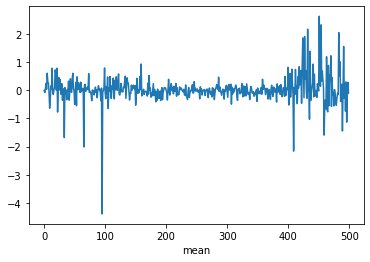

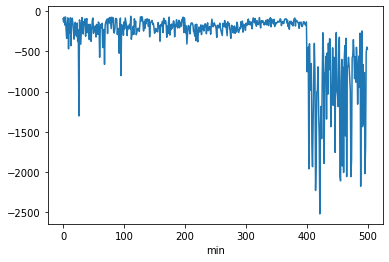

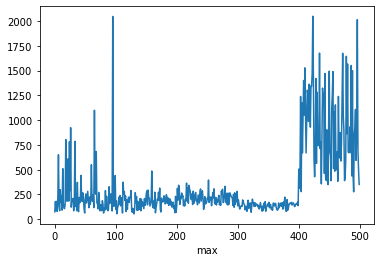

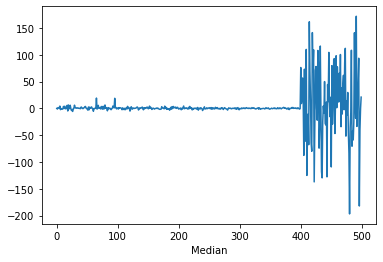

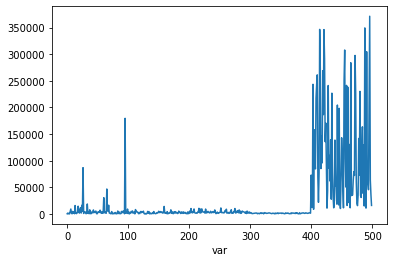

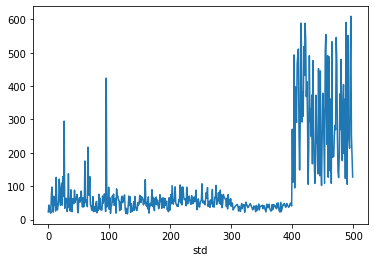

In [6]:
plt.plot(mean)
plt.xlabel("mean")
plt.show()
plt.plot(min)
plt.xlabel("min")
plt.show()
plt.plot(max)
plt.xlabel("max")
plt.show()
plt.plot(median)
plt.xlabel("Median")
plt.show()
plt.plot(var)
plt.xlabel("var")
plt.show()
plt.plot(std)
plt.xlabel("std")
plt.show()

## model with SVC which is Support Vector Classifier

In [7]:
newx = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                        median.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newx, y, random_state=seed, test_size=0.2)
clf = SVC(kernel='linear', max_iter=1000)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.11


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


---
## antropy features 

In [8]:
singular_value_decomposition=np.array([ent.svd_entropy(x[ind, :], normalize=True) for ind in range(x.shape[0])])
singular_value_decomposition.shape

(500,)

In [9]:
Number_of_zerocross=np.array([ent.num_zerocross(x[ind, :], normalize=True) for ind in range(x.shape[0])])
Number_of_zerocross.shape

(500,)

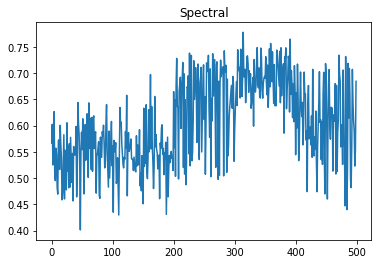

In [10]:
spectral=np.array([ent.spectral_entropy(x[ind, :], sf=100, method='welch', normalize=True) for ind in range(x.shape[0])])
spectral.shape
plt.title('Spectral')
plt.plot(spectral)
plt.show()

In [11]:
np.array([ent.lziv_complexity('01111000011001', normalize=True) for ind in range(x.shape[0])]).shape

(500,)

In [12]:
singular_value_decomposition=np.array([ent.perm_entropy(x[ind, :], normalize=True) for ind in range(x.shape[0])])
singular_value_decomposition.shape

(500,)

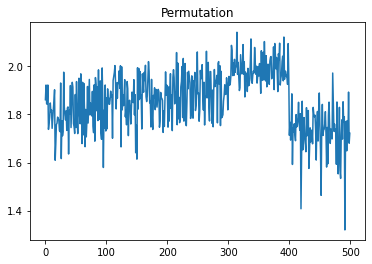

In [13]:
permutation = np.array([ent.perm_entropy(x[i, :]) for i in range(x.shape[0])])
plt.title('Permutation')
plt.plot(permutation)
plt.show()

___
## Fourier Transforms 

Fourier analysis is a method for expressing a function as a sum of periodic components, and for recovering the signal from those components. When both the function and its Fourier transform are replaced with discretized counterparts, it is called the discrete Fourier transform (DFT). The DFT has become a mainstay of numerical computing in part because of a very fast algorithm for computing it, called the Fast Fourier Transform (FFT), which was known to Gauss (1805) and was brought to light in its current form by Cooley and Tukey [CT65]. Press et al. [NR07] provide an accessible introduction to Fourier analysis and its applications.

In [14]:
from scipy.fft import fft,irfft,fhtoffset
freq = fft(newx)
freq.shape

(500, 5)

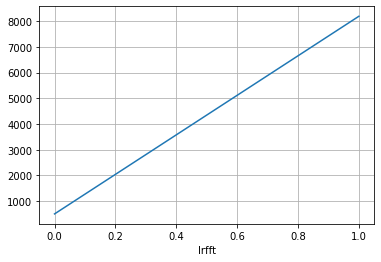

In [15]:
Irfft=irfft(x).shape
plt.plot(Irfft)
plt.xlabel("Irfft")
plt.grid()

Compute the fast Hankel transform.

Computes the discrete Hankel transform of a logarithmically spaced periodic sequence using the FFTLog algorithm

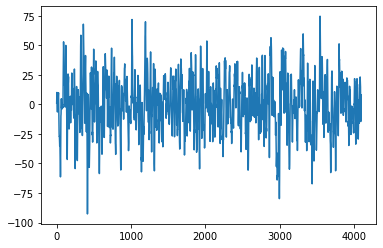

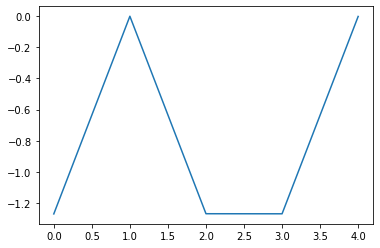

In [16]:
fht=fhtoffset(newx,0,0)
plt.plot(x[0])
plt.show()
plt.plot(fht[0])

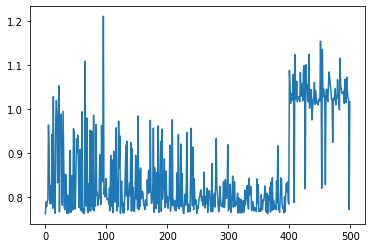

In [17]:
fht_abs = np.abs(fht)
fht_mean = np.mean(fht_abs, axis=1)
fht_var = np.var(fht_abs, axis=1)
plt.plot(fht_mean)

In [18]:
newX = np.concatenate((fht_mean.reshape(-1, 1), fht_var.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newX, y, random_state=seed, test_size=0.2)
clf = SVC(kernel='linear', max_iter=20000, random_state=seed)
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)

print(accuracy_score(y_test, y_pred))

0.99


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


it is a measure of the number of times a signal changes from positive to negative or vice versa in a given time period. 

In [19]:
NegtoPos = np.array([(np.sum(np.abs(np.diff(np.sign(x[ind, :]))))) for ind in range(x.shape[0])])
NegtoPos.shape

(500,)

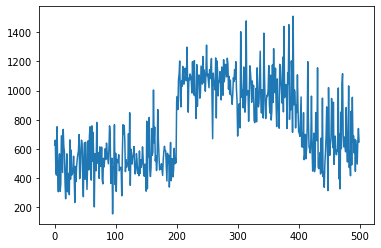

In [20]:
plt.plot(NegtoPos)

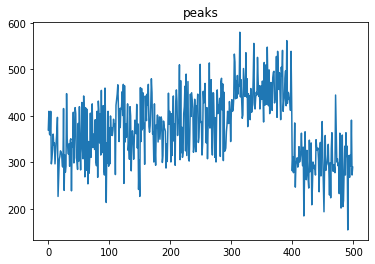

In [21]:
peaks = np.array([find_peaks(x[i, :])[0].shape[0] for i in range(x.shape[0])])

plt.title('peaks')
plt.plot(peaks)
plt.show()

peaks = peaks.reshape(-1, 1)

# LBP

In [22]:
def local_binary_pattern(x, n_points, radius, method='uniform'):
   
    #get the number of samples in the signal
    n_samples = len(x)
    #create empty numpy array for the output LBP of the signal
    lbp = np.zeros(n_samples - 2 * radius)
    #loop over all the samples in the signal
    for i in range(radius, n_samples - radius):
        #get the center value of the signal
        center = x[i]
        #get the values of the neighbours
        val_neighbours = x[i - radius:i + radius + 1]
        #get the LBP code
        code = 0
        for j, val in enumerate(val_neighbours):
            if j != radius:
                if val >= center:
                    code += 1
                code = code << 1
        #remove the last bit
        code = code >> 1
        #set the code in the LBP image
        lbp[i - radius] = code
    return lbp

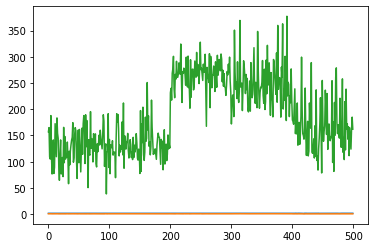

In [23]:
lbp = np.array([local_binary_pattern(x[ind, :], 8, 1, method='uniform') for ind in range(x.shape[0])])
lbp_mean = np.mean(lbp, axis=1)
lbp_var = np.var(lbp, axis=1)
plt.plot(lbp_mean)
plt.plot(lbp_var)
ups = np.sum(np.diff(np.sign(x)) != 0, axis=1) / 2
plt.plot(ups)

In [24]:
newx = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                           median.reshape(-1, 1), lbp_mean.reshape(-1, 1), lbp_var.reshape(-1, 1),peaks), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newx, y, random_state=seed, test_size=0.2)
newx.shape
print(newx)

[[ 5.20426250e+02 -4.10541852e-03  7.46880989e+01 ...  1.51257631e+00
   6.11258198e-01  3.70000000e+02]
 [ 1.89970269e+03 -7.79047666e-02  1.78154673e+02 ...  1.49792430e+00
   6.50484092e-01  4.10000000e+02]
 [ 5.31121467e+02  5.08492028e-02  8.55170956e+01 ...  1.53113553e+00
   6.01167331e-01  3.61000000e+02]
 ...
 [ 6.39156750e+04 -2.09154790e-01  6.96188961e+02 ...  1.51868132e+00
   6.31580190e-01  3.91000000e+02]
 [ 3.71193449e+04  2.83596441e-01  5.03299972e+02 ...  1.42417582e+00
   5.10917361e-01  2.73000000e+02]
 [ 1.62138584e+04 -9.28565554e-02  3.50871506e+02 ...  1.55140415e+00
   5.31118297e-01  2.90000000e+02]]


## Random Forest 


class sklearn.ensemble.RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)[source]¶

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19648\4042275164.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)


(400, 8)

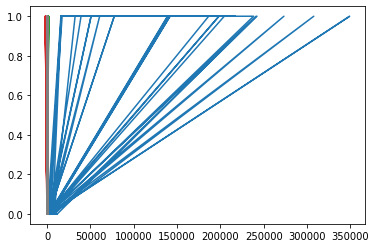

In [25]:
custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
plt.plot(x_test,y_pred)
x_train.shape

# k-fold
K-fold cross-validation is defined as a method for estimating the performance of a model on unseen data. This technique is recommended to be used when the data is scarce and there is an ask to get a good estimate of training and generalization error thereby understanding the aspects such as underfitting and overfitting. This technique is used for hyperparameter tuning such that the model with the most optimal value of hyperparameters can be trained.  It is a resampling technique without replacement. The advantage of this approach is that each example is used for training and validation (as part of a test fold) exactly once. This yields a lower-variance estimate of the model performance than the holdout method. As mentioned earlier, this technique is used because it helps to avoid overfitting, which can occur when a model is trained using all of the data. By using k-fold cross-validation, we are able to “test” the model on k different data sets, which helps to ensure that the model is generalizable.

In [26]:
custom_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
x_train.shape
kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
results = cross_validate(estimator=custom_clf, X=newX, y=y, cv=kfold, scoring={'accuracy': make_scorer(accuracy_score),
                                                                               'precision': make_scorer(precision_score),'recall': make_scorer(recall_score)})
results

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19648\4051477332.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  custom_clf.fit(x_train, y_train)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.p

{'fit_time': array([0.12255597, 0.11066723, 0.11741519, 0.11460781, 0.16936994]),
 'score_time': array([0.00994539, 0.00896645, 0.00896788, 0.01396322, 0.00897694]),
 'test_accuracy': array([0.98, 0.98, 0.98, 0.98, 0.96]),
 'test_precision': array([1.        , 0.9       , 1.        , 0.92857143, 0.89473684]),
 'test_recall': array([0.92307692, 1.        , 0.91304348, 0.92857143, 0.89473684])}

In [27]:
scores = cross_val_score(custom_clf, newx, y, cv=5)
scores.mean()

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\asus\appdata\local\programs\python\py

0.966

# roc

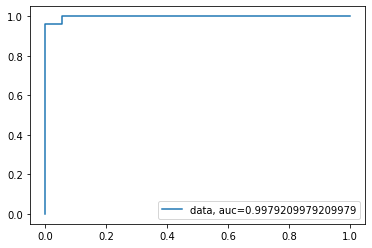

In [28]:
y_pred_proba = custom_clf.predict_proba(x_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# k-means algorithm

In [29]:
custom_clf = KNeighborsClassifier(n_neighbors=2)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
accuracy_score(y_test, y_pred)


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.91

In [30]:
recall_score(y_test, y_pred)

0.6538461538461539

In [31]:
newx = np.concatenate((var.reshape(-1, 1), mean.reshape(-1, 1), max.reshape(-1, 1), min.reshape(-1, 1),
                           median.reshape(-1, 1),std.reshape(-1, 1), lbp_mean.reshape(-1, 1), lbp_var.reshape(-1, 1),
                           fht_mean.reshape(-1, 1), fht_var.reshape(-1, 1),peaks.reshape(-1,1),singular_value_decomposition.reshape(-1, 1)
                      ,spectral.reshape(-1, 1),permutation.reshape(-1, 1)), axis=1)
x_train, x_test, y_train, y_test = train_test_split(newx, y, random_state=seed, test_size=0.2)
newx.shape
print(newx)

[[ 5.20426250e+02 -4.10541852e-03  7.46880989e+01 ...  7.20125951e-01
   5.66975849e-01  1.86149858e+00]
 [ 1.89970269e+03 -7.79047666e-02  1.78154673e+02 ...  7.43690123e-01
   6.02513361e-01  1.92241108e+00]
 [ 5.31121467e+02  5.08492028e-02  8.55170956e+01 ...  7.13245826e-01
   5.25038998e-01  1.84371371e+00]
 ...
 [ 6.39156750e+04 -2.09154790e-01  6.96188961e+02 ...  7.32314392e-01
   5.22902085e-01  1.89300524e+00]
 [ 3.71193449e+04  2.83596441e-01  5.03299972e+02 ...  6.50073478e-01
   5.52191709e-01  1.68041556e+00]
 [ 1.62138584e+04 -9.28565554e-02  3.50871506e+02 ...  6.66167856e-01
   6.84467934e-01  1.72201893e+00]]


## KNeighborsClassifier

In [32]:
custom_clf = KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
accuracy_score(y_test, y_pred)

c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.95

In [33]:
recall_score(y_test, y_pred)

0.8076923076923077

# Normalize

In [34]:
def def_normalize(x):
    return (x-np.mean(x))/(np.max(x)-np.min(x))

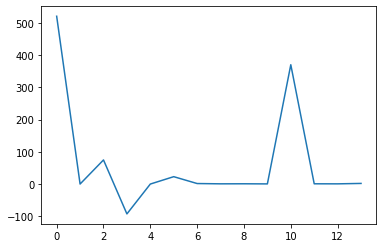

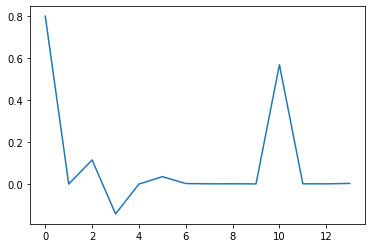

In [35]:
##normalized=def_normalize(newx)
normalized=normalize(newx)
plt.plot(newx[0])
plt.show()
plt.plot(normalized[0])
plt.show()

# SVM

In [36]:
clf = SVC(kernel='rbf', max_iter=2000000000, C=10, random_state=0)
clf.fit(x_train, y_train)
y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))
print(recall_score(y_test, y_prediction))
print(precision_score(y_test, y_prediction))

0.93
0.7307692307692307
1.0


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


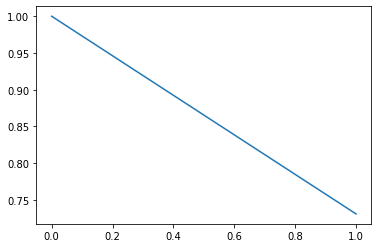

In [37]:
plt.plot(recall_score(y_test, y_prediction, average=None))

In [38]:
clf = SVC(kernel='poly', max_iter=2000000000, C=10, random_state=0)
clf.fit(x_train, y_train)
y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))
print(recall_score(y_test, y_prediction))
print(precision_score(y_test, y_prediction))

0.89
0.5769230769230769
1.0


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [39]:
normalizedX = StandardScaler().fit_transform(newx) 
normalizedX.shape

(500, 14)

0.95

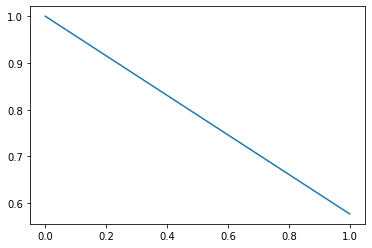

In [40]:
plt.plot(recall_score(y_test, y_prediction, average=None))
accuracy_score(y_test, y_pred)

In [41]:
display = plot_confusion_matrix(clf, x_test, y_test, display_labels=['Normal', 'Abnormal'], cmap=plt.cm.YlGn, normalize='true')
display.ax_.set_title('Confusion matrix')

plt.show()

print(confusion_matrix(y_test, y_prediction))

NameError: name 'plot_confusion_matrix' is not defined

### calculate correlation of each feature and compare it with other features

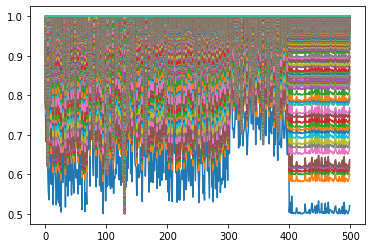

In [42]:
correlation=np.corrcoef(newx)

correlation = np.abs(correlation)
correlation = np.sort(correlation, axis=1)
plt.plot(correlation)

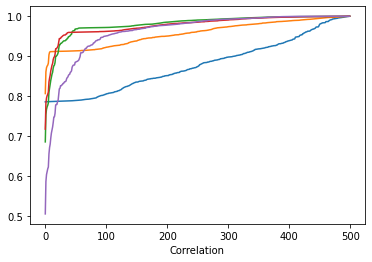

In [43]:
plt.xlabel("Correlation")
for i in range(0, correlation.shape[1], 100):
    plt.plot(correlation[i])

plt.show()

In [44]:
newx

array([[ 5.20426250e+02, -4.10541852e-03,  7.46880989e+01, ...,
         7.20125951e-01,  5.66975849e-01,  1.86149858e+00],
       [ 1.89970269e+03, -7.79047666e-02,  1.78154673e+02, ...,
         7.43690123e-01,  6.02513361e-01,  1.92241108e+00],
       [ 5.31121467e+02,  5.08492028e-02,  8.55170956e+01, ...,
         7.13245826e-01,  5.25038998e-01,  1.84371371e+00],
       ...,
       [ 6.39156750e+04, -2.09154790e-01,  6.96188961e+02, ...,
         7.32314392e-01,  5.22902085e-01,  1.89300524e+00],
       [ 3.71193449e+04,  2.83596441e-01,  5.03299972e+02, ...,
         6.50073478e-01,  5.52191709e-01,  1.68041556e+00],
       [ 1.62138584e+04, -9.28565554e-02,  3.50871506e+02, ...,
         6.66167856e-01,  6.84467934e-01,  1.72201893e+00]])

In [45]:
best_features = []

for i in range(0, newx.shape[1]):
    x = newx[:,i].reshape(-1, 1);
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    
    y_prediction = clf.predict(x_test)

    model_accuracy = accuracy_score(y_test, y_prediction)
    model_recall = recall_score(y_test, y_prediction)
    model_precision = precision_score(y_test, y_prediction)
    
    print(f'feature {i}  accuracy: {model_accuracy}, recall: {model_recall}, precision: {model_precision}')
    
    if model_accuracy > 0.8 and model_recall > 0.7 and model_precision > 0.7:
        best_features.append(i)

feature 0  accuracy: 0.96, recall: 0.8461538461538461, precision: 1.0
feature 1  accuracy: 0.71, recall: 0.2692307692307692, precision: 0.4117647058823529
feature 2  accuracy: 0.94, recall: 0.8076923076923077, precision: 0.9545454545454546
feature 3  accuracy: 0.96, recall: 0.8846153846153846, precision: 0.9583333333333334
feature 4  accuracy: 0.97, recall: 0.8846153846153846, precision: 1.0
feature 5  accuracy: 0.96, recall: 0.8461538461538461, precision: 1.0
feature 6  accuracy: 0.75, recall: 0.2692307692307692, precision: 0.5384615384615384
feature 7  accuracy: 0.73, recall: 0.3076923076923077, precision: 0.47058823529411764
feature 8  accuracy: 0.96, recall: 0.8846153846153846, precision: 0.9583333333333334
feature 9  accuracy: 0.83, recall: 0.5769230769230769, precision: 0.7142857142857143
feature 10  accuracy: 0.75, recall: 0.23076923076923078, precision: 0.5454545454545454
feature 11  accuracy: 0.8, recall: 0.4230769230769231, precision: 0.6875
feature 12  accuracy: 0.6, recall:

feature 0  accuracy: 0.96, recall: 0.8461538461538461, precision: 1.0


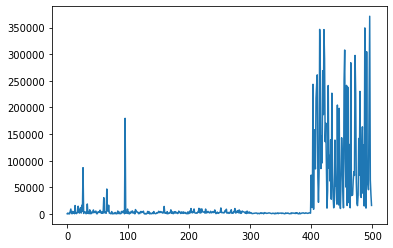

feature 2  accuracy: 0.94, recall: 0.8076923076923077, precision: 0.9545454545454546


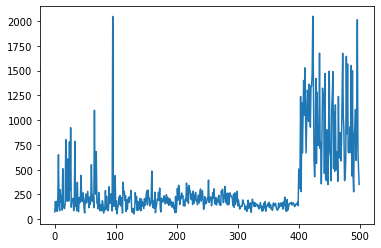

feature 3  accuracy: 0.96, recall: 0.8846153846153846, precision: 0.9583333333333334


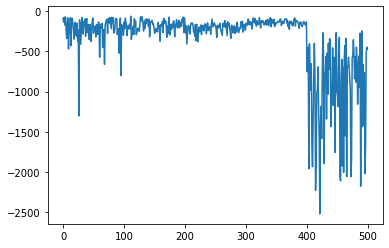

feature 4  accuracy: 0.97, recall: 0.8846153846153846, precision: 1.0


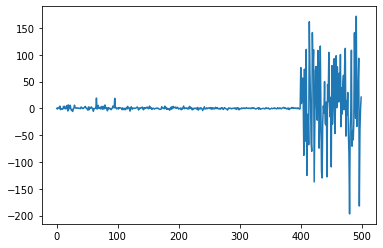

feature 5  accuracy: 0.96, recall: 0.8461538461538461, precision: 1.0


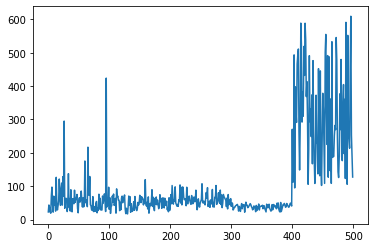

feature 8  accuracy: 0.96, recall: 0.8846153846153846, precision: 0.9583333333333334


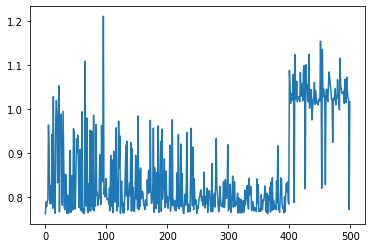

In [46]:
for i in best_features :
    x = newx[:,i].reshape(-1, 1);
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    plt.plot(x)
    clf = DecisionTreeClassifier()
    clf.fit(x_train, y_train)
    
    y_prediction = clf.predict(x_test)

    model_accuracy = accuracy_score(y_test, y_prediction)
    model_recall = recall_score(y_test, y_prediction)
    model_precision = precision_score(y_test, y_prediction)
    
    print(f'feature {i}  accuracy: {model_accuracy}, recall: {model_recall}, precision: {model_precision}')
    plt.show()

## Optimizing Best features 

In [47]:
opt=newx[:,best_features]
print(opt.shape)

(500, 6)


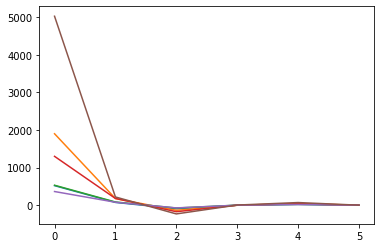

In [48]:
for i in range(opt.shape[1]):
    plt.plot(opt[i])

plt.show()

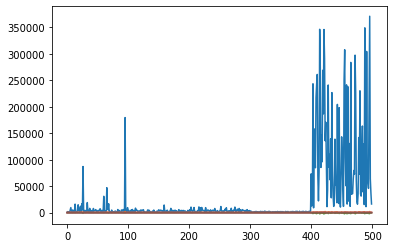

In [49]:
plt.plot(opt)

## classify and get F1 score

In [50]:
sorted_features = []
index = 0
for feature in opt.T:
    index += 1
    x_train, x_test, y_train, y_test = train_test_split(feature.reshape(-1, 1), y, test_size=0.2, random_state=seed)
    custom_clf = DecisionTreeClassifier(random_state=0)
    custom_clf.fit(x_train, y_train)
    y_pred = custom_clf.predict(x_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    model_recall = recall_score(y_test, y_pred)
    model_precision = precision_score(y_test, y_pred)
    model_f1 = f1_score(y_test, y_pred)
    print('feature', index,'(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)
    sorted_features.append((model_f1, feature))
sorted_features.sort(key=lambda x: x[0], reverse=True)
primary_features = np.array(sorted_features[0][1]).reshape(-1, 1)
sorted_features[0][0]

feature 1 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 2 (accuracy, recall, precision, f1): 0.94 0.8076923076923077 0.9545454545454546 0.875
feature 3 (accuracy, recall, precision, f1): 0.96 0.8846153846153846 0.9583333333333334 0.9199999999999999
feature 4 (accuracy, recall, precision, f1): 0.97 0.8846153846153846 1.0 0.9387755102040816
feature 5 (accuracy, recall, precision, f1): 0.96 0.8461538461538461 1.0 0.9166666666666666
feature 6 (accuracy, recall, precision, f1): 0.96 0.8846153846153846 0.9583333333333334 0.9199999999999999


0.9387755102040816

In [51]:
custom_clf = DecisionTreeClassifier(random_state=0)
x_train, x_test, y_train, y_test = train_test_split(sorted_features[0][1].reshape(-1, 1), y, test_size=0.2, random_state=0)
custom_clf.fit(x_train, y_train)
y_pred = custom_clf.predict(x_test)
model_accuracy_old = accuracy_score(y_test, y_pred)
model_recall_old = recall_score(y_test, y_pred)
model_precision_old = precision_score(y_test, y_pred)
model_f1_old = f1_score(y_test, y_pred)
print('feature', i, '(accuracy, recall, precision, f1):', model_accuracy, model_recall, model_precision, model_f1)

feature 5 (accuracy, recall, precision, f1): 0.96 0.8846153846153846 0.9583333333333334 0.9199999999999999


In [57]:
x_train, x_test, y_train, y_test = train_test_split(opt, y, test_size=0.2, random_state=seed, shuffle=True)
kmeans = KMeans(n_clusters=5, random_state=seed).fit(x_train)
print(np.bincount(kmeans.labels_))

[339   9  31   7  14]


c:\users\asus\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


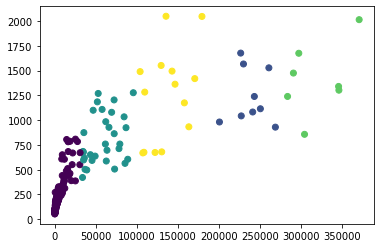

In [59]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=kmeans.labels_, cmap='viridis')

In [60]:
for i in range(0, 5):
    x_train_cluster = x_train[kmeans.labels_ == i]
    y_train_cluster = y_train[kmeans.labels_ == i]
    print(len(x_train_cluster))
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(x_train_cluster, y_train_cluster)
    y_prediction = clf.predict(x_test)
    model_accuracy = accuracy_score(y_test, y_prediction)
    model_recall = recall_score(y_test, y_prediction)
    model_precision = precision_score(y_test, y_prediction)
    print('cluster', i, '(accuracy, recall, precision):', model_accuracy, model_recall, model_precision)

339
cluster 0 (accuracy, recall, precision): 0.99 0.9615384615384616 1.0
9
cluster 1 (accuracy, recall, precision): 0.26 1.0 0.26
31
cluster 2 (accuracy, recall, precision): 0.14 0.5384615384615384 0.1590909090909091
7
cluster 3 (accuracy, recall, precision): 0.26 1.0 0.26
14
cluster 4 (accuracy, recall, precision): 0.16 0.6153846153846154 0.17777777777777778
